<a href="https://colab.research.google.com/github/zoya-ivanova/-Data-Science/blob/main/%D0%94%D0%97_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1.Кластеризация. Метод K-Means

Имеется набор данных Mall_Customers.csv о покупателях супермаркета:


CustomerID — идентификатор покупателя;

Genre — пол;

Age — возраст;

Annual Income (k$) — годовой доход покупателя в тыс. долл.;

Spending Score (1–100) — рейтинг трат покупателя.


Решите задачу кластеризации покупателей, чтобы в дальнейшем планировать маркетинговые акции для каждой группы.



In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [16]:
# Загрузка данных
df = pd.read_csv('/content/Mall_Customers (1).csv')
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [17]:
# Первичный осмотр данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


DataFrame содержит 200 строк, пронумерованных от 0 до 199, 5 столбцов.

In [18]:
# Проверка на пропуски
miss_values = df.isnull().sum()
print(miss_values)

CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


Пропусков нет

In [5]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [6]:
df.describe(include=['object'])

,Genre
count,200
unique,2
top,Female
freq,112


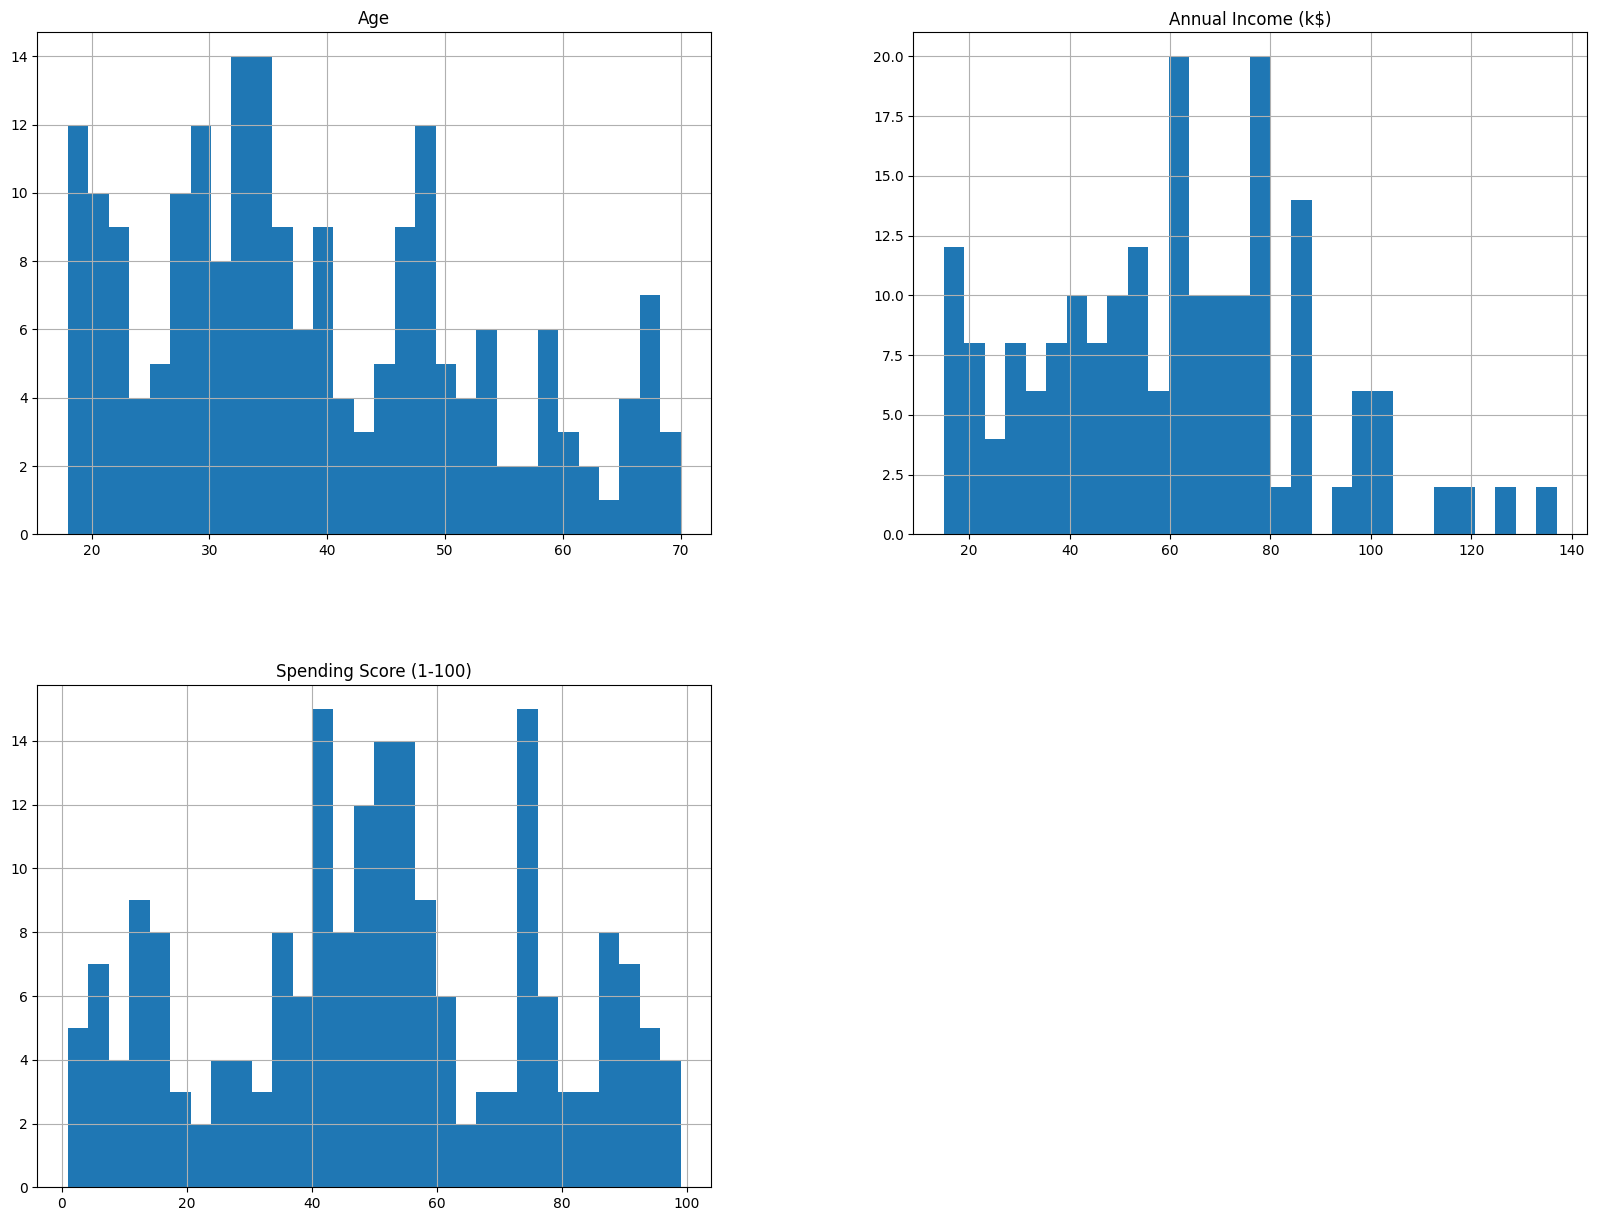

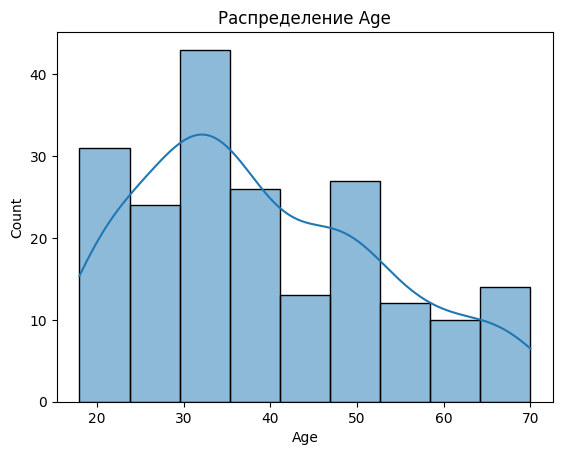

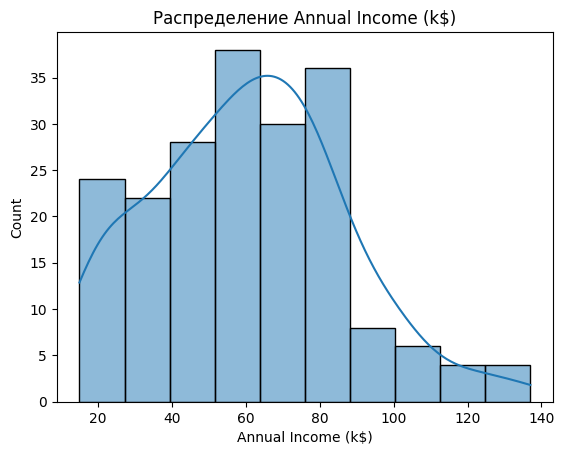

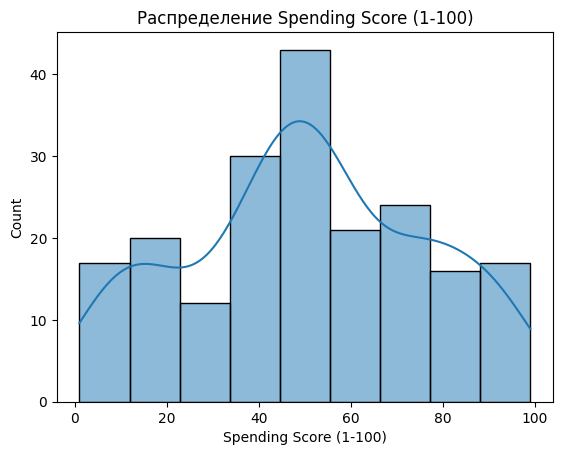

In [7]:
# Построение гистограмм для всех числовых признаков, кроме CustomerID
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
numeric_columns = numeric_columns.drop('CustomerID')

# Гистограммы с помощью pandas
df[numeric_columns].hist(bins=30, figsize=(20, 15))
plt.show()

# Распределения с помощью seaborn
for column in numeric_columns:
    sns.histplot(df[column], kde=True)
    plt.title(f'Распределение {column}')
    plt.show()

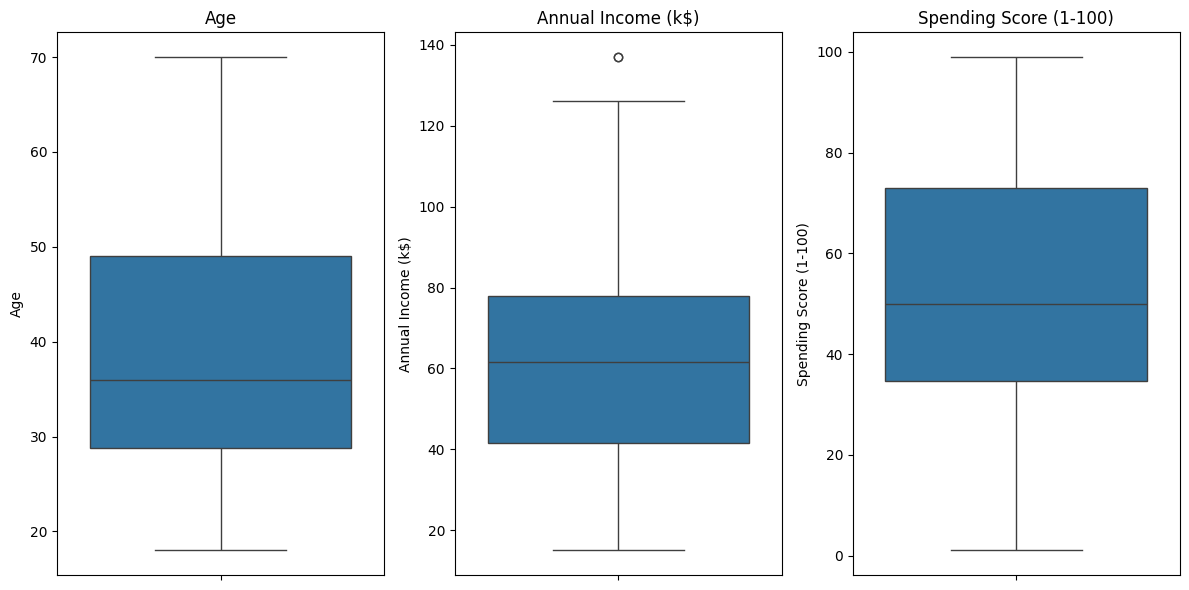

In [8]:
# Построение ящиков с усами
plt.figure(figsize=(12, 6))

# Ящик с усами для 'Age'
plt.subplot(1, 3, 1)
sns.boxplot(y=df['Age'])
plt.title('Age')

# Ящик с усами для 'Annual Income (k$)'
plt.subplot(1, 3, 2)
sns.boxplot(y=df['Annual Income (k$)'])
plt.title('Annual Income (k$)')

# Ящик с усами для 'Spending Score (1-100)'
plt.subplot(1, 3, 3)
sns.boxplot(y=df['Spending Score (1-100)'])
plt.title('Spending Score (1-100)')

plt.tight_layout()
plt.show()

Для определения оптимального количества кластеров в методе k-средних используем метод “локтя” (Elbow Method). Этот метод помогает визуально определить количество кластеров, при котором дальнейшее увеличение числа кластеров не приводит к значительному уменьшению суммы квадратов расстояний до центроидов кластеров

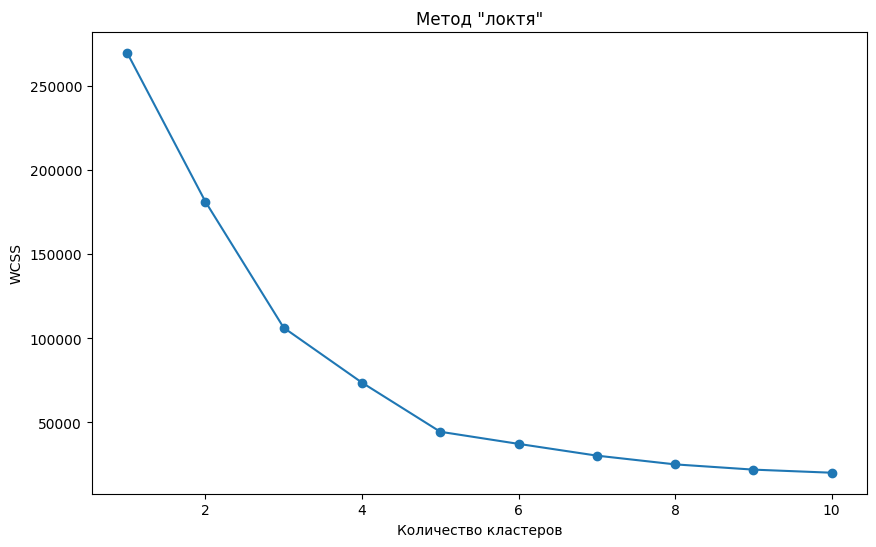

In [19]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Диапазон значений k
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(df[['Annual Income (k$)', 'Spending Score (1-100)']])
    wcss.append(kmeans.inertia_)

# Построение графика метода "локтя"
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Метод "локтя"')
plt.xlabel('Количество кластеров')
plt.ylabel('WCSS')
plt.show()

По графику метода “локтя” наблюдаем, что оптимальное количество кластеров находится в районе 4 или 5. Это видно по тому, что после этой точки уменьшение WCSS становится менее значительным, и график начинает выравниваться. Таким образом, предположим, что 4 кластера будет оптимальным для набора данных.

In [21]:
# Преобразование категориального признака Genre в численный
df['Genre'] = df['Genre'].astype('category')
df['Genre_Code'] = df['Genre'].cat.codes

# Проверка результата
print(df.head())


   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)  \
0           1    Male   19                  15                      39   
1           2    Male   21                  15                      81   
2           3  Female   20                  16                       6   
3           4  Female   23                  16                      77   
4           5  Female   31                  17                      40   

   Genre_Code  
0           1  
1           1  
2           0  
3           0  
4           0  


In [22]:
# Удаление столбца 'ID'
df = df.drop(columns=['CustomerID'])

In [23]:
# Удаление строк с возрастом свыше 100 лет
df = df[df['Age'] <= 100]

In [27]:
# Выбор признаков для кластеризации
X = df[['Genre_Code', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']]
km = KMeans(n_clusters=4)
x = df[['Genre_Code', 'Age']]
km.fit(x)
points = km.predict(x)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<Axes: xlabel='Age', ylabel='Annual Income (k$)'>

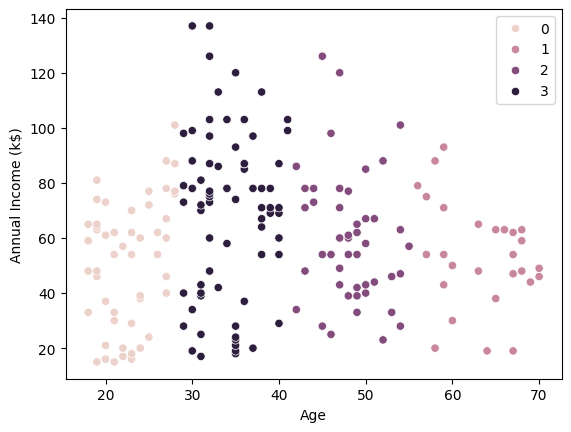

In [30]:
# Посмотрим на результаты кластеризации на графике для 4 кластеров.
sns.scatterplot(data=df, x='Age', y='Annual Income (k$)', hue=points)

In [31]:
# Выбор признаков для кластеризации
X = df[['Genre_Code', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']]
km = KMeans(n_clusters=5)
x = df[['Genre_Code', 'Age']]
km.fit(x)
points = km.predict(x)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<Axes: xlabel='Age', ylabel='Annual Income (k$)'>

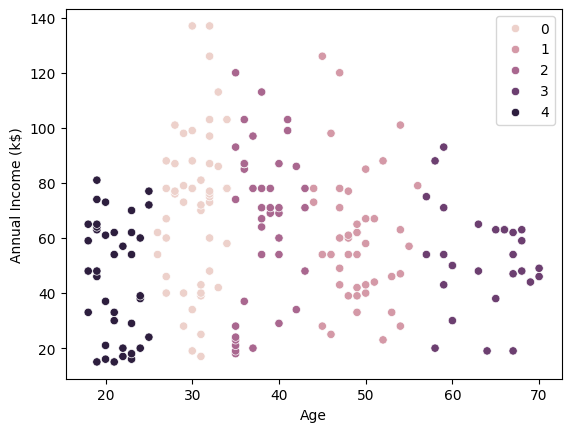

In [32]:
# Посмотрим на результаты кластеризации на графике для 5 кластеров.
sns.scatterplot(data=df, x='Age', y='Annual Income (k$)', hue=points)

Посчитаем оптимальным все же 5 кластеров (после визуализации)

In [33]:
# Оптимальное количество кластеров (5)
optimal_clusters = 5

# Построение модели k-средних
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
y_kmeans = kmeans.fit_predict(X)

# Добавление результатов кластеризации в исходный DataFrame
df['Cluster'] = y_kmeans

# Проверка результатов
print(df.head())

    Genre  Age  Annual Income (k$)  Spending Score (1-100)  Genre_Code  \
0    Male   19                  15                      39           1   
1    Male   21                  15                      81           1   
2  Female   20                  16                       6           0   
3  Female   23                  16                      77           0   
4  Female   31                  17                      40           0   

   Cluster  
0        0  
1        4  
2        0  
3        4  
4        0  


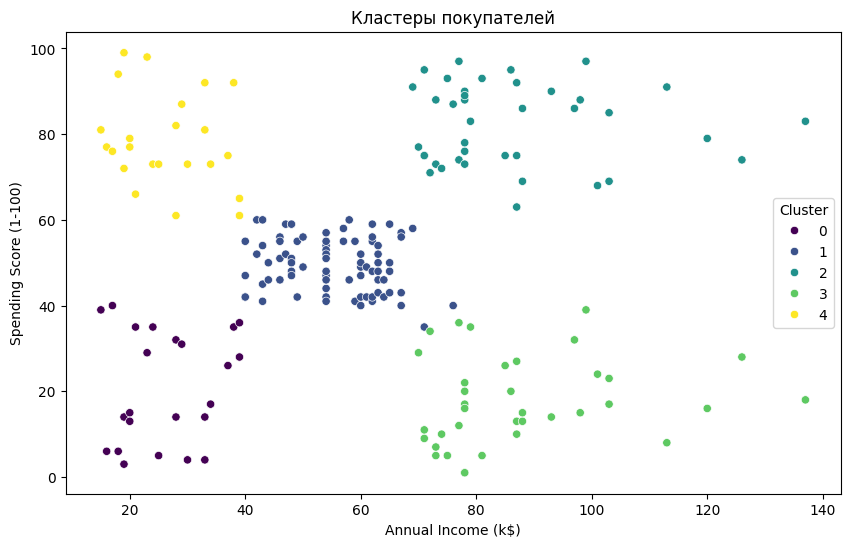

In [35]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster', data=df, palette='viridis') # Changed 'Spending Score (1–100)' to 'Spending Score (1-100)'
plt.title('Кластеры покупателей')
plt.show()

### 2.Кластеризация. DBSCAN

Имеется набор данных `gt_2015.csv` о производительности и других параметрах ветряных электростанций:
* AT — температура окружающей среды.
* PT — давление окружающей среды.
* AH — влажность окружающей среды.
* AFDP — перепад давления на воздушном фильтре.
* GTEP — давление на выходе из газовой турбины.
* TIT — температура на входе в турбину.
* TAT — температура на выходе из турбины.
* TEY — энергоотдача турбины.
* CDP — давление нагнетания компрессора.
* CO — выбросы угарного газа.
* NOX — выбросы оксидов азота.

Решите задачу кластеризации электростанций для дальнейшего совместного управления схожими электростанциями.

In [36]:
# Загрузка данных
df = pd.read_csv('/content/gt_2015.csv')
df.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,1.95320,1020.1,84.985,2.5304,20.116,1048.7,544.92,116.27,10.799,7.4491,113.250
1,1.21910,1020.1,87.523,2.3937,18.584,1045.5,548.50,109.18,10.347,6.4684,112.020
2,0.94915,1022.2,78.335,2.7789,22.264,1068.8,549.95,125.88,11.256,3.6335,88.147
3,1.00750,1021.7,76.942,2.8170,23.358,1075.2,549.63,132.21,11.702,3.1972,87.078
4,1.28580,1021.6,76.732,2.8377,23.483,1076.2,549.68,133.58,11.737,2.3833,82.515


In [37]:
# Первичный осмотр данных
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7384 entries, 0 to 7383
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      7384 non-null   float64
 1   AP      7384 non-null   float64
 2   AH      7384 non-null   float64
 3   AFDP    7384 non-null   float64
 4   GTEP    7384 non-null   float64
 5   TIT     7384 non-null   float64
 6   TAT     7384 non-null   float64
 7   TEY     7384 non-null   float64
 8   CDP     7384 non-null   float64
 9   CO      7384 non-null   float64
 10  NOX     7384 non-null   float64
dtypes: float64(11)
memory usage: 634.7 KB
None


In [40]:
# Проверка на пропуски
miss_values = df.isnull().sum()
print(miss_values)

AT      0
AP      0
AH      0
AFDP    0
GTEP    0
TIT     0
TAT     0
TEY     0
CDP     0
CO      0
NOX     0
dtype: int64


Пропусков нет

In [39]:
df.describe()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
count,7384.000000,7384.00000,7384.000000,7384.000000,7384.000000,7384.000000,7384.000000,7384.000000,7384.000000,7384.000000,7384.000000
mean,17.225259,1014.50911,68.647464,3.598909,26.130149,1078.974689,546.642484,133.993380,12.097025,3.129986,59.890509
std,8.095783,6.89543,13.541116,0.610226,4.473737,19.762449,5.489066,16.179208,1.136601,2.234962,11.132464
min,-6.234800,989.40000,24.085000,2.368800,17.698000,1016.000000,516.040000,100.020000,9.870800,0.212800,25.905000
25%,11.073250,1009.67500,59.447250,3.117300,23.147000,1070.500000,544.747500,126.255000,11.465750,1.808175,52.399000
50%,17.456500,1014.00000,70.952000,3.538500,25.331000,1080.300000,549.720000,131.600000,11.933000,2.533400,56.838500
75%,23.684750,1018.30000,79.653750,4.194825,30.018250,1099.900000,550.030000,147.160000,13.148000,3.702550,65.093250
max,37.103000,1036.60000,96.666000,5.239500,40.716000,1100.400000,550.590000,179.500000,15.159000,41.097000,119.680000


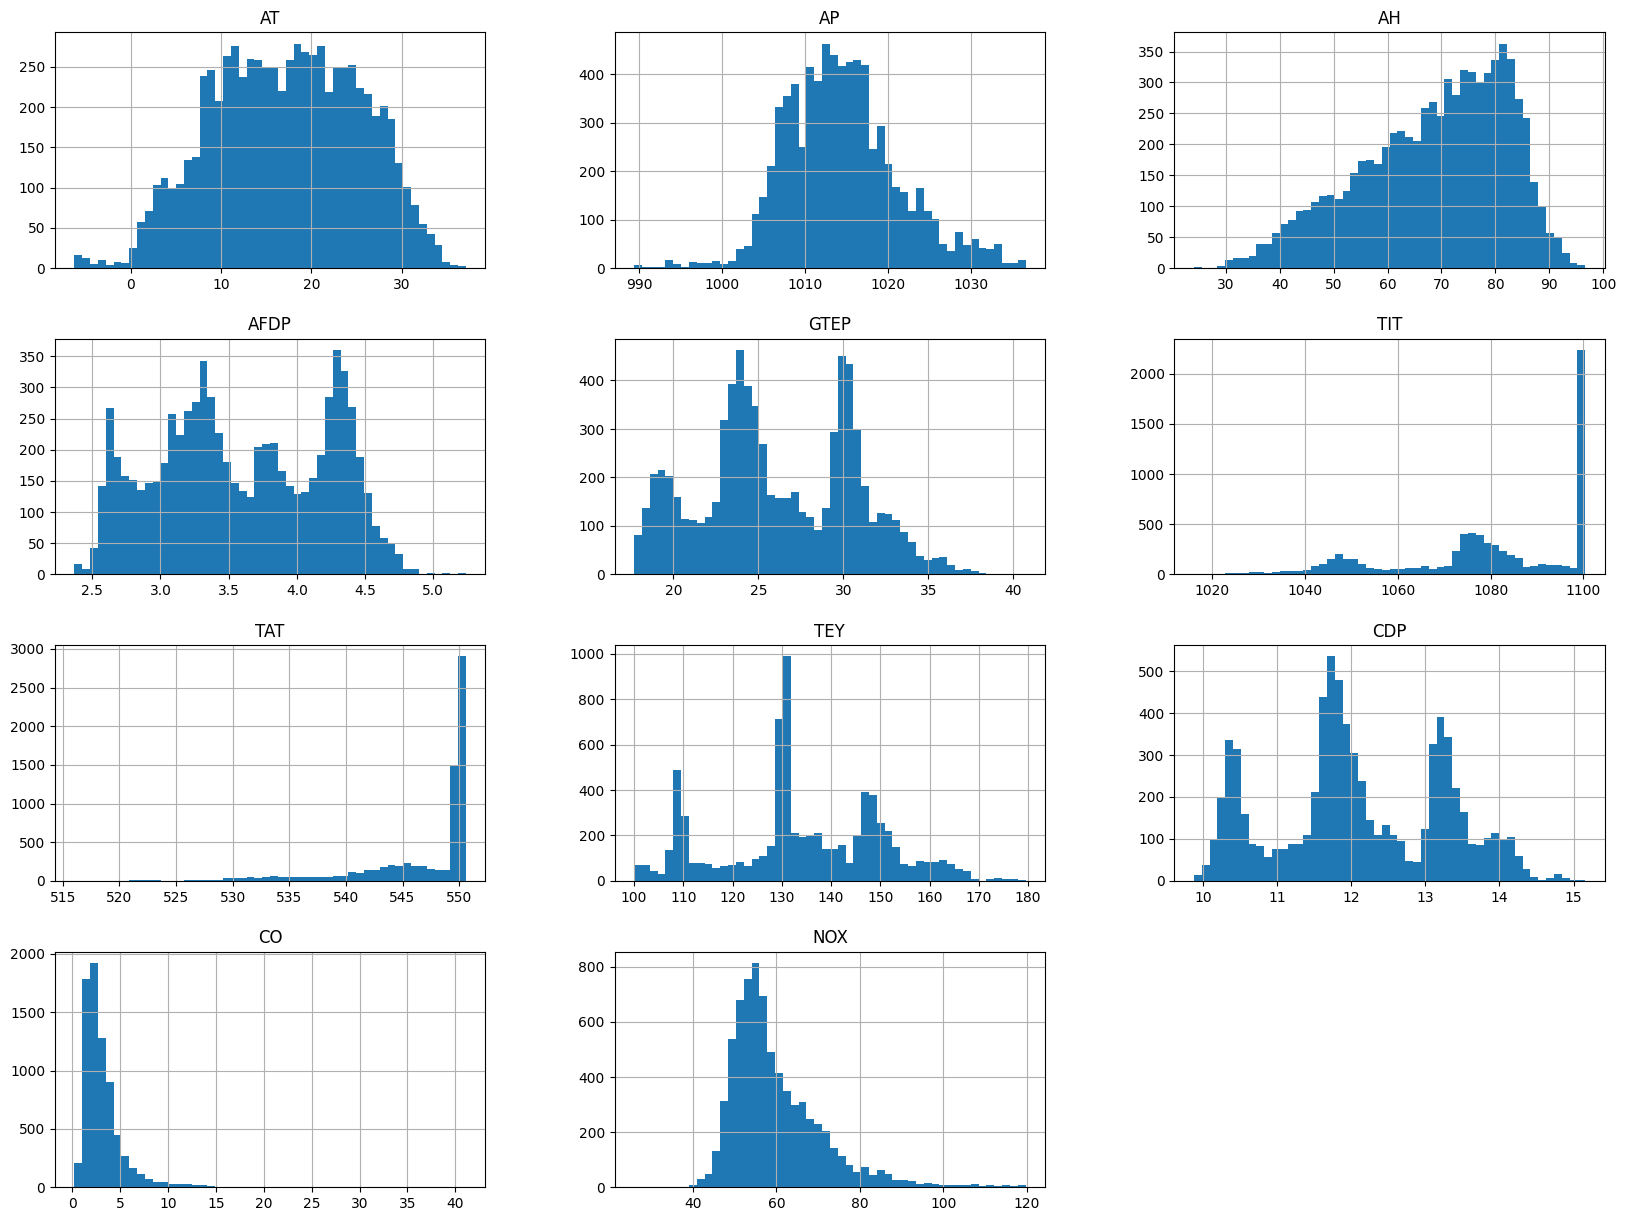

In [41]:
# Гистограммы для каждого параметра
df.hist(bins=50, figsize=(20, 15))
plt.show()

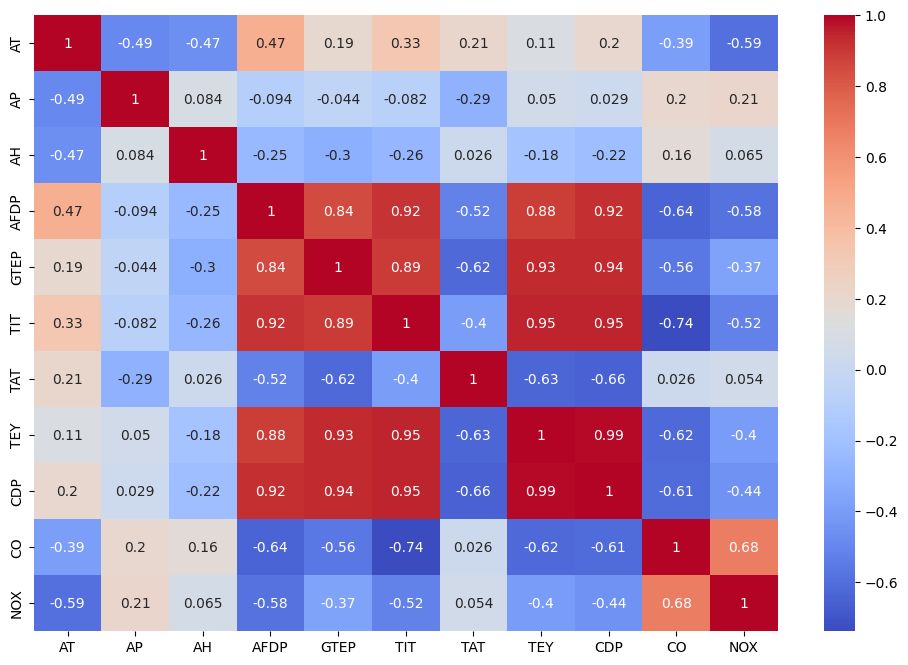

In [42]:
# Корреляционная матрица
corr_matrix = df.corr()

# Тепловая карта корреляций
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

Для определения групп электростанций используем кластерный анализ

In [43]:
from sklearn.preprocessing import StandardScaler

# Нормализация данных
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

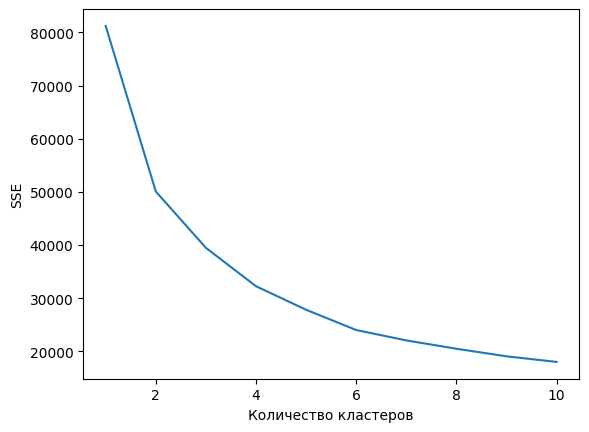

In [44]:
# Определение оптимального количества кластеров с помощью метода локтя
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse)
plt.xlabel('Количество кластеров')
plt.ylabel('SSE')
plt.show()

Можно разделить на 3 группы (кластера):
Кластер 1: Электростанции с высокой энергоотдачей и низкими выбросами.
Кластер 2: Электростанции с низкой энергоотдачей и высокими выбросами.
Кластер 3: Электростанции со средними значениями всех параметров.

In [47]:
# Cеточный поиск

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

# Сеточный поиск по гиперпараметрам eps и min_samples
eps_values = np.arange(0.1, 1.5, 0.1)
min_samples_values = range(2, 10)
best_score = -1
best_params = {}

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(scaled_data)
        if len(set(labels)) > 1:  # Проверка, что найдено больше одного кластера
            score = silhouette_score(scaled_data, labels)
            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}

print(f"Лучшие параметры: {best_params}")

Лучшие параметры: {'eps': 1.4000000000000001, 'min_samples': 9}


In [48]:
# Построение модели с лучшими параметрами
dbscan = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
df['Cluster'] = dbscan.fit_predict(scaled_data)

In [49]:
# Количество кластеров
num_clusters = len(set(df['Cluster'])) - (1 if -1 in df['Cluster'] else 0)
print(f"Количество кластеров: {num_clusters}")

# Средние значения параметров для каждого кластера
cluster_means = df.groupby('Cluster').mean()
print(cluster_means)

Количество кластеров: 2
                AT           AP         AH      AFDP       GTEP          TIT  \
Cluster                                                                        
-1        9.792084  1017.174370  66.162790  3.390948  25.884605  1063.886555   
 0       17.347014  1014.465454  68.688163  3.602315  26.134171  1079.221831   

                TAT         TEY        CDP        CO        NOX  
Cluster                                                          
-1       539.051765  130.312437  11.889082  8.198870  79.380521  
 0       546.766819  134.053674  12.100431  3.046958  59.571265  


Метод локтя используется для определения оптимального количества кластеров в данных и выделил 3 кластера.

Метод DBSCAN (Density-Based Spatial Clustering of Applications with Noise) выделил 2 кластера, основываясь на плотности данных:

Кластер -1: Это шум, включающий точки данных, которые не принадлежат ни одному из кластеров. Характеризуется более низкими значениями температуры окружающей среды, давления и энергоотдачи, а также более высокими выбросами угарного газа и оксидов азота.

Кластер 0: Основной кластер, содержащий большинство данных, включает электростанции с более высокими значениями температуры, давления и энергоотдачи, а также с более низкими выбросами угарного газа и оксидов азота..